# Forecasting Change in Global Average Land Temparature

The Climate Change: Earth Surface Temperature dataset provides records of the global average land temperature from 1750 to 2015. I will be using this dataset to see if I can train a LTSM model that can accurately forecast the temperature in the future, based on the temperature of previous years. The model will use one-step prediction to predict the average land temperature of the following year, based on a window of data about the previous years. 

At the end, I will also look at building an ARIMA model, to compare the perfomance between a deep learning model (LTSM) and statistical model (ARIMA) for this data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
%matplotlib inline

In [2]:
data = pd.read_csv("GlobalTemperatures.csv")
print(data.shape)
data.head()

(3192, 9)


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data["dt"] = pd.to_datetime(data["dt"])
data = data[["dt", "LandAverageTemperature"]]
data.isnull().sum()

dt                         0
LandAverageTemperature    12
dtype: int64

In [4]:
data = data.dropna()
data.shape

(3180, 2)

In [5]:
data["Year"] = data.dt.dt.year
data = data.groupby(["Year"]).mean()
data

,LandAverageTemperature
Year,
1750,8.719364
1751,7.976143
1752,5.779833
1753,8.388083
1754,8.469333
...,...
2011,9.516000
2012,9.507333
2013,9.606500


I've taken the time series data which stores the average land temperature on every day of every year (between 1750 to 2015), and created a new time series so that I now just have the average land temperature for each year. 

In [6]:
data['LandAverageTemperature_diff'] = data['LandAverageTemperature'].diff()
data = data.dropna()
data = data.reset_index()
data

,Year,LandAverageTemperature,LandAverageTemperature_diff
0,1751,7.976143,-0.743221
1,1752,5.779833,-2.196310
2,1753,8.388083,2.608250
3,1754,8.469333,0.081250
4,1755,8.355583,-0.113750
...,...,...,...
260,2011,9.516000,-0.187083
261,2012,9.507333,-0.008667
262,2013,9.606500,0.099167
263,2014,9.570667,-0.035833


I want to train on a stationary time series, therefore I've take log(x+1) of my time series, and created another new column that stores the change in average land temperature compared to the previous year.

Text(0.5, 1.0, 'Average Land Temperature - 1751-2015 - (Celcius)')

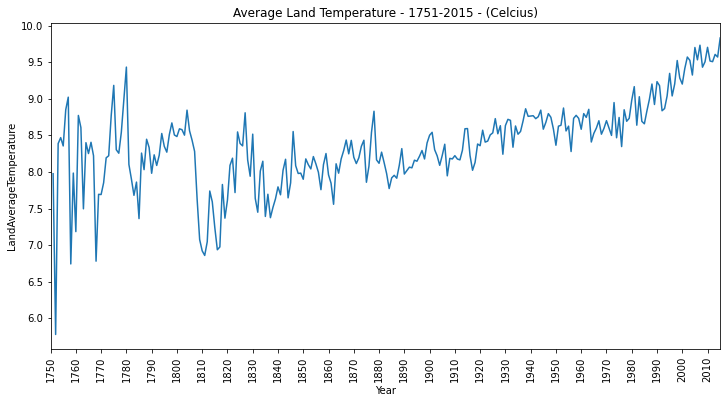

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=data.Year, y=data.LandAverageTemperature, ax=ax)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
ax.set_xlim(1750, 2015)
ax.set_title("Average Land Temperature - 1751-2015 - (Celcius)")

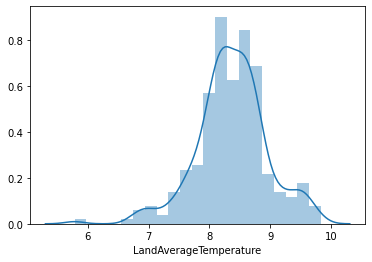

In [8]:
sns.distplot(data.LandAverageTemperature)

Text(0.5, 1.0, 'Difference in Average Land Temperature to Previous Year - 1751-2015 - (Celcius)')

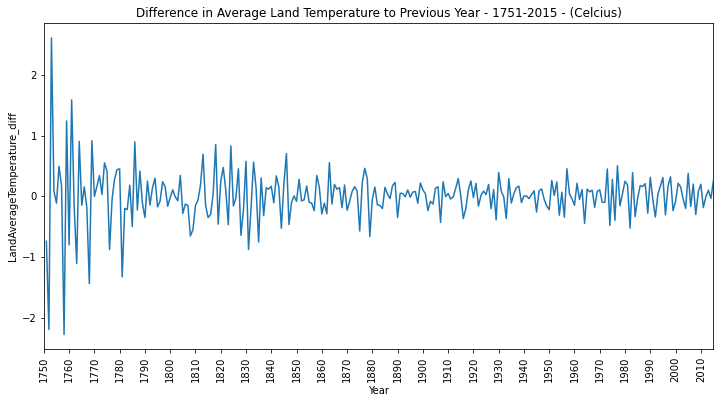

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=data.Year, y=data.LandAverageTemperature_diff, ax=ax)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
ax.set_xlim(1750, 2015)
ax.set_title("Difference in Average Land Temperature to Previous Year - 1751-2015 - (Celcius)")

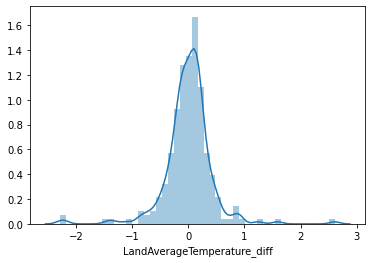

In [10]:
sns.distplot(data.LandAverageTemperature_diff)

# One-step LTSM Model

In [11]:
WINDOW_LENGTH = 30

The window length determines how many previous years of historical data will be used for the model to make predictions. For the one-step model, in order to predict the average temperature for a certain year, the model will use the previous 20 years of data.

In [12]:
train = data[data["Year"] < 1950]
test = data[data["Year"] >= 1950]

train = train.set_index("Year")
test = test.set_index("Year")

In [13]:
x_train = []
for i in range(WINDOW_LENGTH, train.shape[0] - 1):
    x_train.append(np.array(train.iloc[(i - WINDOW_LENGTH):i, 1].copy()).reshape(WINDOW_LENGTH, 1))
x_train = np.array(x_train)
y_train = np.array(train.iloc[WINDOW_LENGTH + 1:, 1].values).reshape(-1, 1)
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)

x_test = []
for i in range(WINDOW_LENGTH, test.shape[0] - 1):
    x_test.append(np.array(test.iloc[(i - WINDOW_LENGTH):i, 1].copy()).reshape(WINDOW_LENGTH, 1))
x_test = np.array(x_test)
y_test = np.array(test.iloc[WINDOW_LENGTH + 1:, 1].values).reshape(-1, 1)
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (168, 30, 1)
y train shape:  (168, 1)
X test shape:  (35, 30, 1)
y test shape:  (35, 1)


In [14]:
model = Sequential()
model.add(LSTM(50, input_shape=(WINDOW_LENGTH, 1)))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train, y_train, batch_size=4, validation_data=(x_test, y_test), epochs=500, shuffle=True, verbose=0)

Train MAE: 0.03849464902343868
Test MAE: 0.22594883753032888


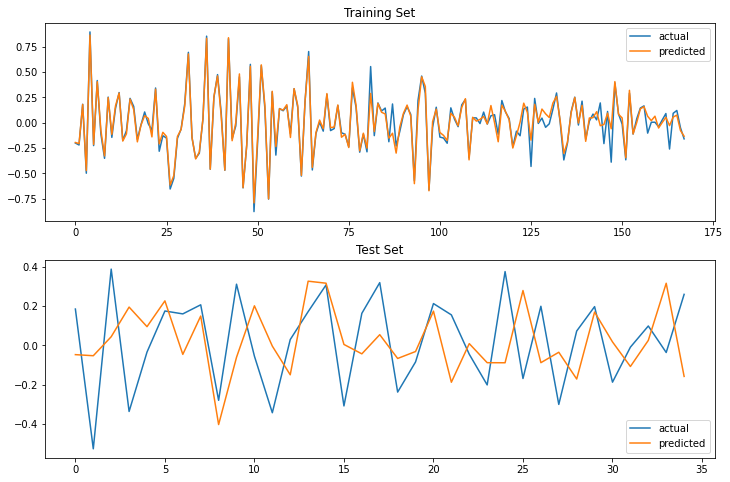

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

y_pred = model.predict(x_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train MAE: {}'.format(mae))

ax[0].plot(y_train, label="actual")
ax[0].plot(y_pred, label="predicted")
ax[0].set_title("Training Set")

y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {}'.format(mae))

ax[1].plot(y_test, label="actual")
ax[1].plot(y_pred, label="predicted")
ax[1].set_title("Test Set")

for ax in fig.axes:
    plt.sca(ax)
    plt.legend()
plt.show()

The model has fit fairly well to the training data, however it's very messy at matching the test data. The train MAE of 0.0385 and test MAE of 0.226 indicates that the model is overfitting. Let's convert the model's predictions back to average land temperature per year, rather than the change from the previous year, to see how the predicted forecast looks compared to the actual one. 

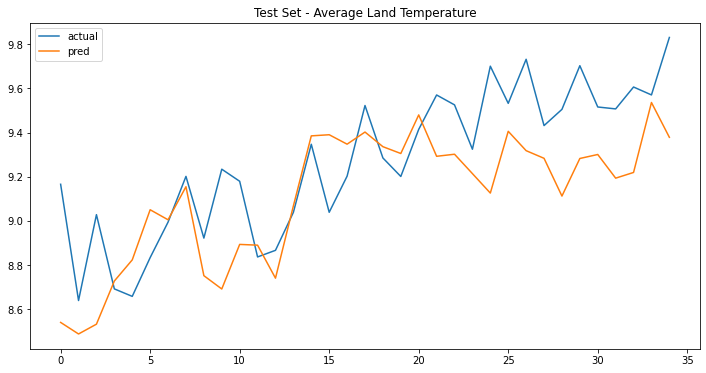

In [17]:
test_actual_avg_temp = np.array(test.iloc[WINDOW_LENGTH + 1:, 0].values)

pred_avg_temp = []
pred_avg_temp.append(train.iloc[-1:, 0].values[0])

for i in range(len(test_actual_avg_temp)):
    pred_avg_temp.append(pred_avg_temp[i] + y_pred[i,0])
    
plt.figure(figsize=(12,6))
plt.plot(test_actual_avg_temp, label="actual")
plt.plot(pred_avg_temp[1:], label="pred")
plt.legend()
plt.title("Test Set - Average Land Temperature")
plt.show()

The predicted forecast matches the actual forecast fairly well here. However it's underestimating the rise in temperature for the more distant future (i.e. beyond 20 years into the future).

# ARIMA Model
As a comparison, I will also quickly look at a simple ARIMA model to forecast the same data. We'll see if the forecast accuracy is any better when using a statistical model like ARIMA, rather than an LTSM deep learning model. 

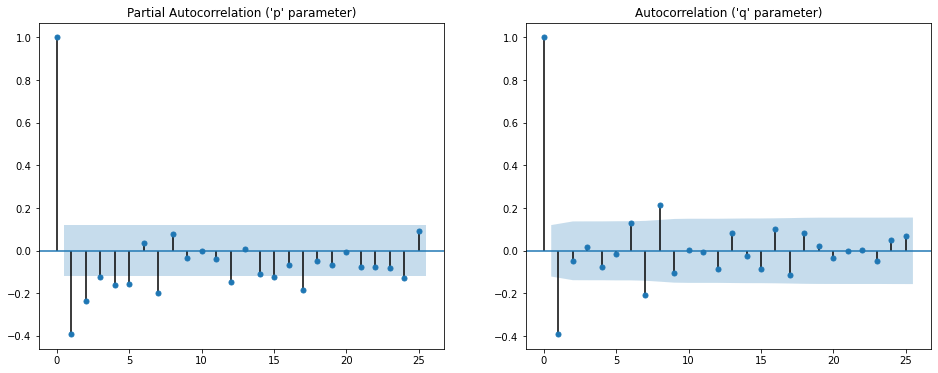

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
plot_pacf(data.LandAverageTemperature.diff().dropna(), ax=ax[0])
plot_acf(data.LandAverageTemperature.diff().dropna(), ax=ax[1])
ax[0].set_title("Partial Autocorrelation ('p' parameter)")
ax[1].set_title("Autocorrelation ('q' parameter)")
plt.show()

The graphs above help me to choose the values of 'p' and 'q' for the ARIMA model. From looking at these graphs, I will set both values to 1.

In [19]:
TEST_SIZE = 20
x_train = data.LandAverageTemperature[:-TEST_SIZE]
x_test = data.LandAverageTemperature[-TEST_SIZE:]

arima_model = ARIMA(x_train, order=(1, 2, 1))  
arima_model_fit = arima_model.fit(disp=-1)
print(arima_model_fit.summary())

                                 ARIMA Model Results                                 
Dep. Variable:     D2.LandAverageTemperature   No. Observations:                  243
Model:                        ARIMA(1, 2, 1)   Log Likelihood                -128.193
Method:                              css-mle   S.D. of innovations              0.405
Date:                       Wed, 05 Aug 2020   AIC                            264.386
Time:                               13:38:38   BIC                            278.358
Sample:                                    2   HQIC                           270.014
                                                                                     
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            2.279e-06      0.000      0.009      0.993      -0.001       0.001
ar.L1.D2.Lan

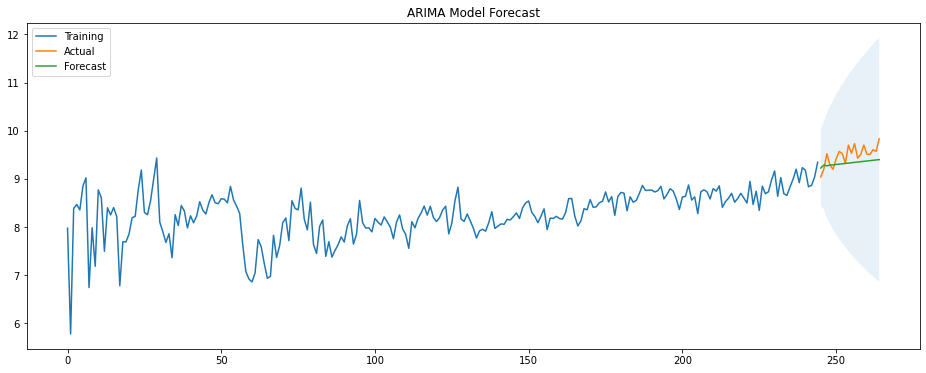

In [20]:
forecast, stderr, conf_int = arima_model_fit.forecast(TEST_SIZE, alpha=0.05)

plt.figure(figsize=(16,6))
plt.plot(x_train, label='Training')
plt.plot(x_test, label='Actual')
plt.plot(x_test.index, forecast, label='Forecast')
plt.fill_between(x_test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.1)
plt.title('ARIMA Model Forecast')
plt.legend(loc='upper left')
plt.show()

The shaded blue region indicates the confidence interval for the predicted forecast. The actual forecast is well within the confidence interval, and the predicted forecast follows the correct upwards direction of the actual forecast. This ARIMA model seems to do quite well at forecasting 20 years into the future, based on the training data. 

# Conclusion
Using the calculated average land temperature per year, there are only 265 values in the dataset to use in total. This is not a lot of data to train these models on, yet both the LTSM model and ARIMA model seem to have fitted rather well to data, and the accuracy of their forecasts for the average land temperature is not too bad. 

I'd still like to experiment further with the hyperparameters for the LTSM model, as I was finding better results when using a lower batch size and higher number of epochs. I could still look at trying different optimisers for the model, or a different number of LTSM layers/neurons. 